In [3]:
using Plots
using LinearAlgebra
using DifferentialEquations
using Random

In [4]:
include("DTM.jl")
include("lorentz_system.jl")
include("RK4.jl")
include("EulerCromer.jl")
include("UsefulFunctions.jl")

EulerCromer (generic function with 1 method)

In [5]:
function Correlation(vec1,vec2)
    return sum(vec1.*vec2)/norm(vec1)/norm(vec2)
end

Correlation (generic function with 1 method)

In [ ]:
'
function Path(ẋ::Function, tsteps, x̄₀, p)
    x̄=x̄₀
    Δt = tsteps[1]
    X = zeros(3,length(tsteps))
    for i=1:length(tsteps)-1
        X[:,i] = x̄
        x̄= ẋ(p,x̄,Δt)
        Δt = tsteps[i+1]-tsteps[i]
        println(Δt)
    end
    return X
end
'

In [6]:
# Finds path for starting position x̄₀
function Path(ẋ::Function, Δt, tim, x̄₀, p)
    tsteps = Int(tim/Δt)
    x̄=x̄₀
    X = zeros(3,tsteps)
    for i=1:tsteps
        x̄= ẋ(p,x̄,Δt)
        X[:,i] = x̄
    end
    return X
end

Path (generic function with 1 method)

In [49]:
function Plot_Correlation(Δt,time,inital_vals,p)
    
    plt=plot()
    for x̄₀ in eachcol(inital_vals)
        X = Path(DTM, Δt, time, x̄₀, p)

        tsteps = Int(time/Δt)
        x̄=x̄₀
        XA5 = zeros(3,tsteps)
        for i=1:tsteps
            prob = ODEProblem(LorentzSystem,x̄₀,(0.0,Δt*i),[θ,μ,β])
            sol = solve(prob, RadauIIA5())
            x̄= sol[end]
            XA5[:,i] = x̄
        end

        correlation = zeros(tsteps)
        for i=1:tsteps
            correlation[i] = Correlation(XA5[:,i],X[:,i])
        end

        plot!(plt,range(0,stop=time-Δt,step=Δt),correlation,label="x₀ = $x̄₀")
    end
    display(plt)

end

Plot_Correlation (generic function with 1 method)

In [74]:
function Plot_Correlation(Δt,time,inital_vals,p)
    
    plt=plot()
    for x̄₀ in eachcol(inital_vals)
        X = Path(DTM, Δt, time, x̄₀, p)

        tsteps = Int(time/Δt)
        x̄=x̄₀
        XA5 = zeros(3,tsteps)
        
        prob = ODEProblem(LorentzSystem,x̄₀,(0.0,time),[θ,μ,β])
        sol = solve(prob, RadauIIA5(),adaptive=false, dt=Δt)

        correlation = zeros(tsteps)
        for i=1:tsteps
            correlation[i] = Correlation(sol.u[i,1],X[:,i])
        end

        plot!(plt,range(0,stop=time-Δt,step=Δt),correlation,label="x₀ = $x̄₀")
    end
    display(plt)

end

Plot_Correlation (generic function with 1 method)

In [70]:
prob = ODEProblem(LorentzSystem,x̄₀,(0.0,time),[θ,μ,β])
sol = solve(prob, RadauIIA5(),adaptive=false, dt=Δt)
sol.u[1,:]'

1×1 adjoint(::Vector{Vector{Float64}}) with eltype Adjoint{Float64, Vector{Float64}}:
 [10.0 17.0 33.0]

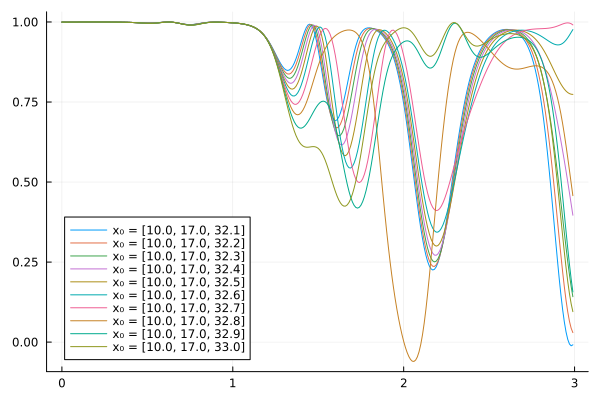

In [73]:
Plot_Correlation_ver2(Δt,time,initial_vals,p)

In [175]:
function Plot_Correlation_Histogram(Δt,time,inital_vals,p,oursolver=DTM,juliasolver=RadauIIA5())
    
    #plt=plot()
    correlations=zeros(length(inital_vals[1,:]))
    j=1
    for x̄₀ in eachcol(inital_vals)
        #X = Path(oursolver, Δt, time, x̄₀, p)

        tsteps = Int(time/Δt)
        x̄=x̄₀
        prob = ODEProblem(LorentzSystem,x̄₀,(0.0,time),[θ,μ,β])
        sol = solve(prob, RadauIIA5(),adaptive=false, dt=Δt)
        sol2 = solve(prob,  RadauIIA5(),adaptive=false, dt=Δt/2)

        correlation = 1
        i=1
        while correlation > 0.5 && i<tsteps
            correlation = Correlation(sol2.u[2*i,1],sol.u[i,1])
            i+=1
        end
        correlations[j] = i*Δt
        j=j+1
    end
    plot(initial_vals[3,:],correlations, seriestype= :bar, ylabel= "time", xlabel= "initial z value", legend=false, dpi=300)

end

Plot_Correlation_Histogram (generic function with 3 methods)

In [10]:
function Plot_Correlation_Histogram2d(Δt,time,x̄₀,nr_of_initial_vals,p,oursolver=DTM,juliasolver=RadauIIA5())
    correlations=zeros(nr_of_initial_vals,nr_of_initial_vals)
    for m = 1:nr_of_initial_vals
        for n = 1:nr_of_initial_vals
            
            x̄ = x̄₀+[m-nr_of_initial_vals/2;n-nr_of_initial_vals/2;0]
            X = Path(oursolver, Δt, time, x̄, p)

            tsteps = Int(time/Δt)
            prob = ODEProblem(LorentzSystem,x̄,(0.0,time),[θ,μ,β])
            sol = solve(prob, juliasolver,adaptive=false, dt=Δt)

            correlation = 1
            i=1
            while correlation > 0.5 && i<tsteps
                correlation = Correlation(sol.u[i,1],X[:,i])
                i+=1
            end

            correlations[m,n] = i*Δt
            
            
        end
    end

    surface((x̄₀[1]-nr_of_initial_vals/2):(x̄₀[1]+nr_of_initial_vals/2)-1,(x̄₀[2]-nr_of_initial_vals/2):(x̄₀[2]+nr_of_initial_vals/2)-1,correlations,xlabel="x",ylabel="y",zlabel="correlation time",dpi=300)
    savefig("plots/correlation_RK4_01_Radau_01.png")
end

Plot_Correlation_Histogram2d (generic function with 3 methods)

In [12]:

Plot_Correlation_Histogram2d(0.01,time,x̄₀,40,p,RK4)

"/Users/00eila01/01_Arbete/UTBILDNING/KEXET/Numerical-Solutions-and-Parameter-Sensitivity-of-the-Lorentz-System-Degree-Project-in-Technology/Numerical-Solvers/plots/correlation_RK4_01_Radau_01.png"

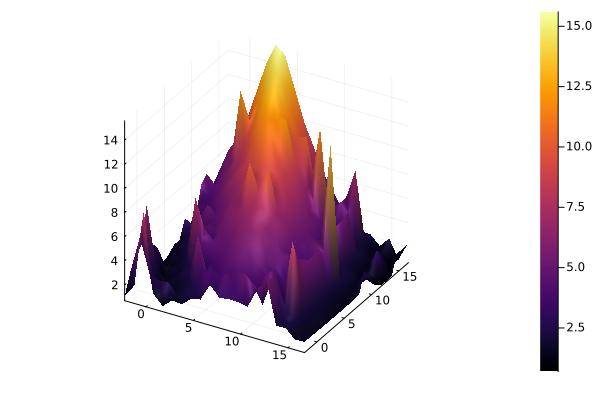

In [244]:
#plot(surface(z=correlations,x=(x̄₀[1]-20/2):(x̄₀[1]+20/2),y=(x̄₀[2]-20/2):(x̄₀[2]+20/2)))
surface((x̄₀[1]-10):(x̄₀[1]+10)-1,(x̄₀[2]-10):(x̄₀[2]+10)-1,correlations)

In [241]:
println(length((x̄₀[1]-10):(x̄₀[1]+10)))
println(size(correlations))

21
(20, 20)


In [81]:
function Plot_Correlation_Heatmap(Δt,time,inital_vals,p)
    
    #plt=plot()
    tsteps = Int(time/Δt)
    correlations=zeros(length(inital_vals[1,:]),tsteps)
    j=1
    for x̄₀ in eachcol(inital_vals)
        X = Path(DTM, Δt, time, x̄₀, p)
        x̄=x̄₀
        prob = ODEProblem(LorentzSystem,x̄₀,(0.0,time),[θ,μ,β])
        sol = solve(prob, RadauIIA5(),adaptive=false, dt=Δt)

        for i=1:tsteps
            correlations[j,i] = Correlation(sol.u[i,1],X[:,i])
        end
    end

    return correlations
end

Plot_Correlation_Heatmap (generic function with 1 method)

In [8]:
## parameter values
θ = 10.0; β = 8/3; μ = 28
p=[θ,μ,β]
time = 100
Δt = 0.01
# initial values
x̄₀ = [sqrt(8*22.5/3);
      sqrt(8*22.5/3);
      22.5]

nr=150
initial_vals = zeros(3,nr)
for i=1:nr
    initial_vals[:,i] = x̄₀ + [0; 0;-100+i]
end

In [176]:
Plot_Correlation_Histogram(Δt,time,initial_vals,p) # prova göra en yta :)))))
savefig("plots/correlation_histogram_radau_dt01_radau_dt_005.png")

"/Users/00eila01/01_Arbete/UTBILDNING/KEXET/Numerical-Solutions-and-Parameter-Sensitivity-of-the-Lorentz-System-Degree-Project-in-Technology/Numerical-Solvers/correlation_histogram_radau_dt01_radau_dt_005.png"

In [177]:
Plot_Correlation_Histogram(Δt,time,initial_vals,p,RK4,RadauIIA5())
savefig("plots/correlation_histogram_RK4_dt01_radau_dt_005.png")

"/Users/00eila01/01_Arbete/UTBILDNING/KEXET/Numerical-Solutions-and-Parameter-Sensitivity-of-the-Lorentz-System-Degree-Project-in-Technology/Numerical-Solvers/plots/correlation_histogram_RK4_dt01_radau_dt_005.png"

In [179]:
correlations=Plot_Correlation_Heatmap(Δt,time,initial_vals,p)

150×10000 Matrix{Float64}:
 0.998998  0.999127  0.999301  0.999483  …  0.826611  0.816267  0.804524
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0       …  0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 ⋮                                       ⋱                      
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0     

In [180]:
plot(initial_vals[3,:],range(0,stop=time-Δt,step=Δt), correlations,seriestype= :heatmap, ylabel= "time", xlabel= "initial z value", legend=false)
savefig("plots/kul_plot.png")

"/Users/00eila01/01_Arbete/UTBILDNING/KEXET/Numerical-Solutions-and-Parameter-Sensitivity-of-the-Lorentz-System-Degree-Project-in-Technology/Numerical-Solvers/plots/kul_plot.png"

In [230]:
print(size(correlations))
print(range(0,stop=time-Δt,step=Δt))

(5, 300)0.0:0.01:2.99

In [ ]:
gr()
heatmap(1:3,1:3,[1 1.5 1.6; 1 2 ; 1 1.1 1.2])

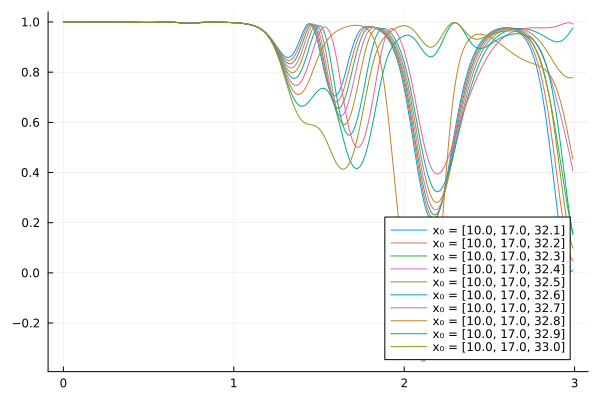

In [50]:
Plot_Correlation(Δt,time,initial_vals,p)

In [119]:
prob = ODEProblem(LorentzSystem,x̄₀,(0.0,time),[θ,μ,β])
sol = solve(prob, RadauIIA5())

retcode: Success
Interpolation: 3rd order Hermite
t: 210-element Vector{Float64}:
  0.0
  0.04085729164131705
  0.08550535783960733
  0.12599526578931786
  0.16648517373902838
  0.20920352159053485
  0.2430229020554862
  0.2680444577165736
  0.30436455809385443
  0.34769831338948404
  ⋮
  9.569037104200012
  9.642971720167987
  9.705337344292174
  9.76770296841636
  9.830068592540547
  9.878475654418066
  9.930847399104177
  9.983219143790288
 10.0
u: 210-element Vector{Vector{Float64}}:
 [10.0, 17.0, 33.0]
 [11.743699714202718, 13.356556583216602, 36.12622163718156]
 [11.327692300086882, 8.167691015532561, 37.368366072490446]
 [9.523453145057058, 4.154500492439753, 35.984483385729845]
 [7.263349266393124, 1.7526553625945764, 33.217269952286856]
 [5.123287556227101, 0.7396551667886408, 29.92871321853074]
 [3.835793250524892, 0.6082872826397813, 27.439848611858128]
 [3.1312080878736372, 0.7133369946752136, 25.723131186960867]
 [2.44132665976881, 1.0220719085176868, 23.4297836033668]
 [2

In [120]:
tsteps = Int(time/Δt)
x̄=x̄₀
XA5 = zeros(3,tsteps)
for i=1:tsteps
    prob = ODEProblem(LorentzSystem,x̄₀,(0.0,Δt*i),[θ,μ,β])
    sol = solve(prob, RadauIIA5())
    x̄= sol[end]
    XA5[:,i] = x̄
end

InterruptException: InterruptException:

In [121]:
X = Path(DTM, Δt, time, x̄₀, [θ, μ, β])

3×1000 Matrix{Float64}:
 10.6095  11.0852  11.4299  11.6471  11.7421  …  -3.17078  -3.37713  -3.59807
 16.2561  15.4024  14.447   13.405   12.2978     -5.14572  -5.48751  -5.8596
 33.8263  34.6273  35.3645  36.0043  36.5203     16.2109   15.9608   15.7411

In [122]:
correlation = zeros(tsteps)
for i=1:tsteps
    correlation[i] = Correlation(XA5[:,i],X[:,i])
end

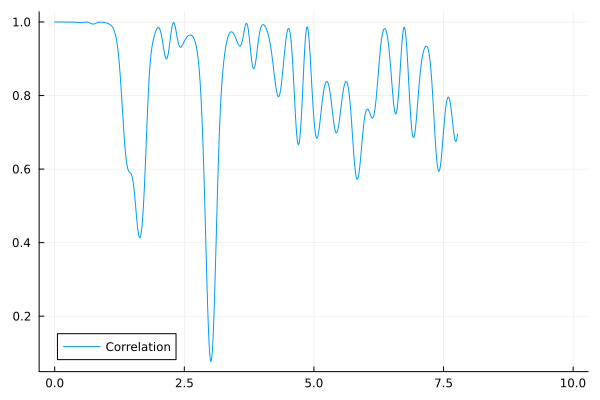

In [123]:
plot(range(0,stop=time-Δt,step=Δt),correlation, label="Correlation")

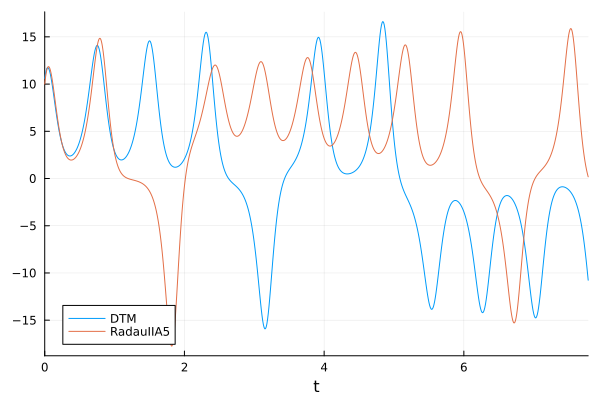

In [124]:
plot(range(0,stop=time-Δt,step=Δt), X[1,:], label="DTM")
plot!(sol, idxs=(1), label="RadauIIA5")